In [34]:
"""EEGNet - Motor Imagery Classification (Hands vs Feet) - 50 Subjects"""

!pip install mne

import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.signal import welch
import seaborn as sns
import warnings
import joblib
import json
from collections import Counter
import pandas as pd

In [35]:
SUBJECT_IDS = range(1, 101)
RUNS = [5, 9, 13]
FS = 160
T_MIN = 0.5
T_MAX = 6.0
EPOCH_LENGTH = int((T_MAX - T_MIN) * FS) + 1

print(f"🎯 Target: Binary Classification (Hands vs Feet)")
print(f"👥 Total Subjects: {len(SUBJECT_IDS)}")
print(f"⏱️ Timepoints per Trial: {EPOCH_LENGTH}")

🎯 Target: Binary Classification (Hands vs Feet)
👥 Total Subjects: 100
⏱️ Timepoints per Trial: 881


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Data berhasil dimuat dan digabung.
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info |

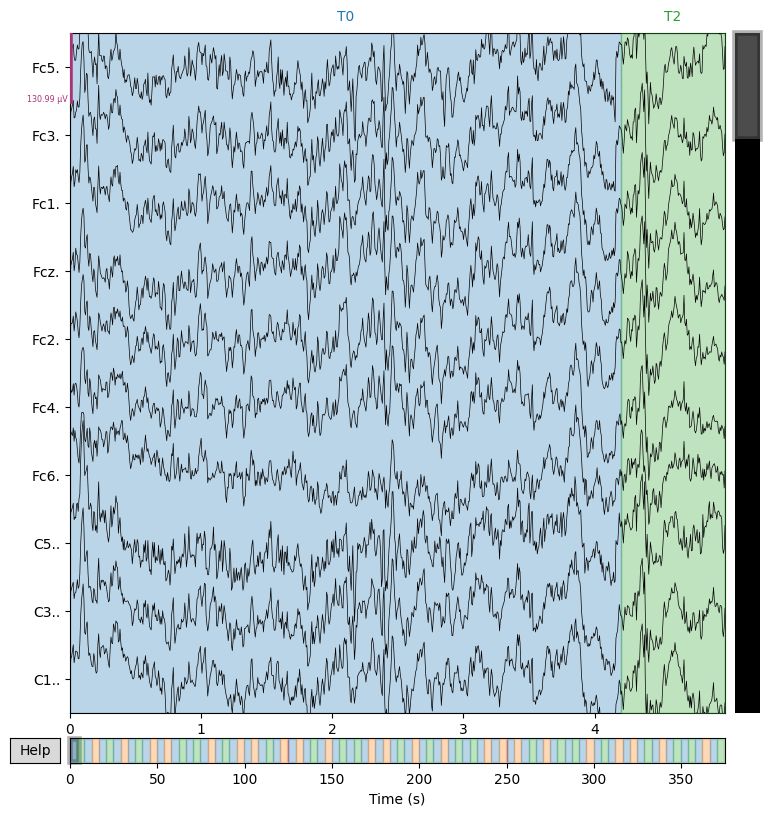

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
--- Informasi Label (Events) ---
Event ID (Label ke Angka):
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [36]:
subject_id = 1
runs = [5, 9, 13]

fnames = mne.datasets.eegbci.load_data(subject_id, runs)

raws = [mne.io.read_raw_edf(f, preload=True) for f in fnames]
raw = mne.io.concatenate_raws(raws)

print("Data berhasil dimuat dan digabung.")

print(raw.info)

sampling_rate = raw.info['sfreq']
n_channels = raw.info['nchan']
channel_names = raw.info['ch_names']

print(f"--- Informasi Struktur Data ---")
print(f"1. Sampling Rate: {sampling_rate} Hz")
print(f"2. Jumlah Channel: {n_channels}")
print(f"3. Daftar Nama Channel (contoh 5 pertama): {channel_names[:5]}")
print(f"4. Format Data Mentah: Data dimuat dari file .edf")
print(f"   Total Durasi Data: {raw.times.max():.2f} detik")

raw.plot(duration=5, n_channels=10, scalings='auto', title='Contoh Sinyal EEG Mentah')

events, event_id = mne.events_from_annotations(raw)

print("--- Informasi Label (Events) ---")
print("Event ID (Label ke Angka):")
print(event_id)


Total events ditemukan: 90
Bentuk array events (sample_index, 0, event_code):
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]

--- Distribusi Label Kelas ---
Label: T0 (Kode: 1) 	-> Jumlah Trials: 45
Label: T2 (Kode: 3) 	-> Jumlah Trials: 22
Label: T1 (Kode: 2) 	-> Jumlah Trials: 23


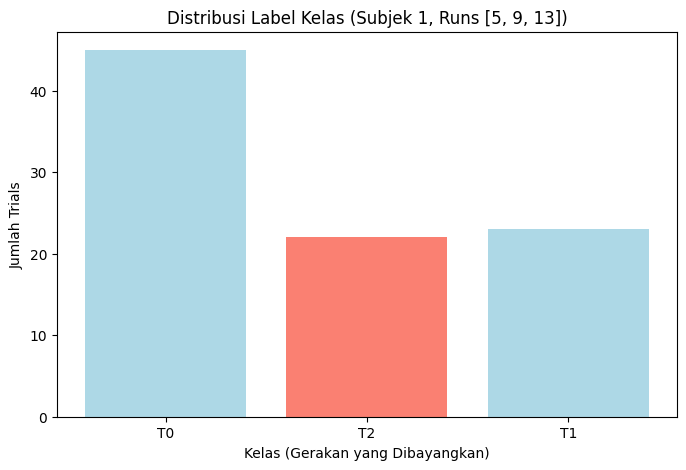

In [37]:
print(f"\nTotal events ditemukan: {len(events)}")
print("Bentuk array events (sample_index, 0, event_code):")
print(events[:5])

event_codes = events[:, 2]

event_counts = Counter(event_codes)

labels_map = {v: k for k, v in event_id.items()}

print("\n--- Distribusi Label Kelas ---")
for code, count in event_counts.items():
    if code in labels_map:
        print(f"Label: {labels_map[code]} (Kode: {code}) \t-> Jumlah Trials: {count}")

labels = [labels_map[code] for code, count in event_counts.items() if code in labels_map]
counts = [count for code, count in event_counts.items() if code in labels_map]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['lightblue', 'salmon'])
plt.title(f'Distribusi Label Kelas (Subjek {subject_id}, Runs {runs})')
plt.xlabel('Kelas (Gerakan yang Dibayangkan)')
plt.ylabel('Jumlah Trials')
plt.show()

In [38]:
subjects_to_check = range(1, 101)

runs = [5, 9, 13]

all_subject_data = []

print(f"Akan memulai inspeksi untuk {len(list(subjects_to_check))} subjek...")

warnings.filterwarnings('ignore')

for sub_id in subjects_to_check:
    print(f"\nMemproses Subjek {sub_id}...")

    try:
        fnames = mne.datasets.eegbci.load_data(sub_id, runs)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f) for f in fnames])

        sfreq = raw.info['sfreq']
        n_channels = raw.info['nchan']

        events, event_map = mne.events_from_annotations(raw)

        counts = Counter(events[:, 2])
        t1_count = counts.get(event_map.get('T1', 99), 0)
        t2_count = counts.get(event_map.get('T2', 98), 0)

        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': sfreq,
            'Jml Channel': n_channels,
            'Trials T1 (Tangan)': t1_count,
            'Trials T2 (Kaki)': t2_count,
            'Status': 'OK'
        })

    except Exception as e:
        print(f"GAGAL memproses Subjek {sub_id}. Error: {e}")
        all_subject_data.append({
            'Subjek': sub_id,
            'Sampling Rate': 'N/A',
            'Jml Channel': 'N/A',
            'Trials T1 (Tangan)': 'N/A',
            'Trials T2 (Kaki)': 'N/A',
            'Status': 'Error'
        })

print("\n--- Inspeksi Selesai ---")



Akan memulai inspeksi untuk 100 subjek...

Memproses Subjek 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Memproses Subjek 2...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R09.edf...
Setting channel info structure...
Creating raw.info structur

Tabel Ringkasan EDA untuk Subjek 1-15:


,Sampling Rate,Jml Channel,Trials T1 (Tangan),Trials T2 (Kaki),Status
Subjek,,,,,
1,160.0,64,23,22,OK
2,160.0,64,21,24,OK
3,160.0,64,22,23,OK
4,160.0,64,22,23,OK
5,160.0,64,22,23,OK
...,...,...,...,...,...
96,160.0,64,24,21,OK
97,160.0,64,24,21,OK
98,160.0,64,23,22,OK



--- Analisis Konsistensi Data ---
1. Sampling Rate: TIDAK KONSISTEN
2. Jml Channel:   KONSISTEN
   -> Semua subjek memiliki 64 channels.
3. Keseimbangan Label:
   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: 1.39 trials
   -> Subjek dengan imbalance > 2 trials:
         Imbalance
Subjek           
2               3
13              3
14              3
18              3
20              3
25              3
28              3
31              3
33              3
44              3
54              3
67              3
74              3
81              3
82              3
87              3
88              3
95              3
96              3
97              3

--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---


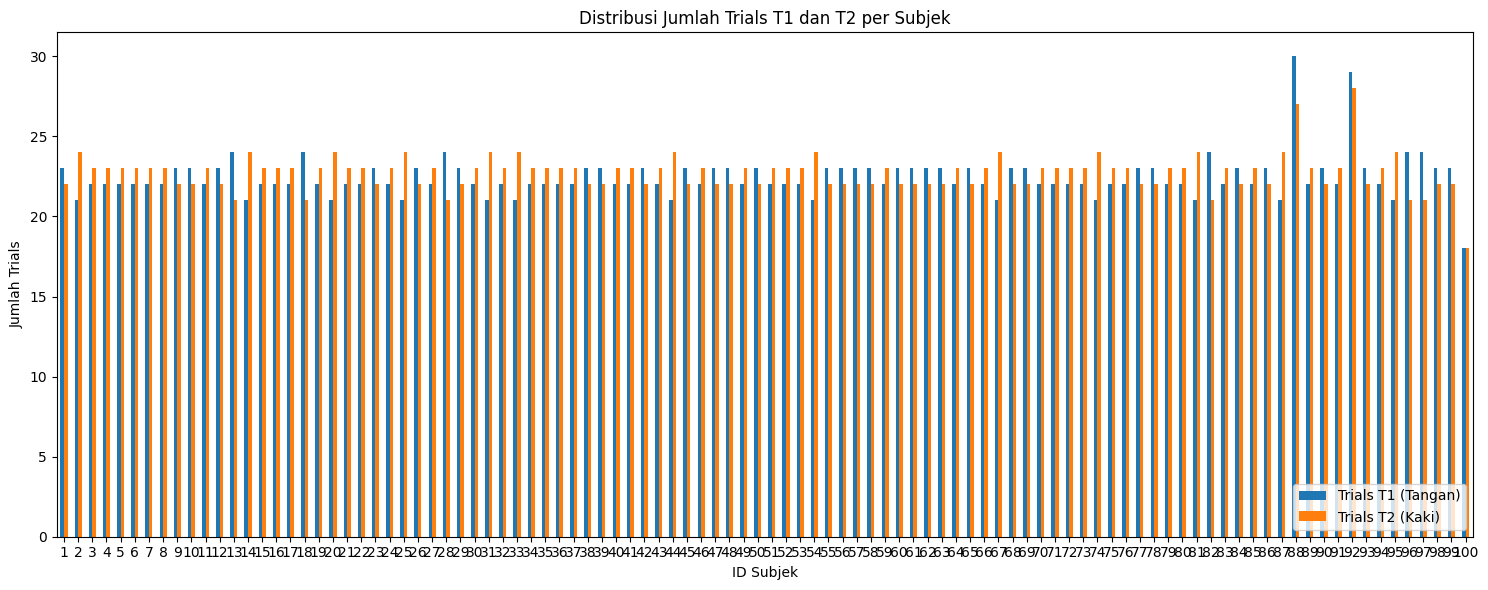

In [39]:
df_results = pd.DataFrame(all_subject_data).set_index('Subjek')

print("Tabel Ringkasan EDA untuk Subjek 1-15:")
display(df_results)

print("\n--- Analisis Konsistensi Data ---")

ok_subjects = df_results[df_results['Status'] == 'OK']

if not ok_subjects.empty:
    sfreq_konsisten = ok_subjects['Sampling Rate'].nunique() == 1
    sfreq_value = ok_subjects['Sampling Rate'].iloc[0]
    print(f"1. Sampling Rate: {'KONSISTEN' if sfreq_konsisten else 'TIDAK KONSISTEN'}")
    if sfreq_konsisten:
        print(f"   -> Semua subjek memiliki {sfreq_value} Hz.")

    ch_konsisten = ok_subjects['Jml Channel'].nunique() == 1
    ch_value = ok_subjects['Jml Channel'].iloc[0]
    print(f"2. Jml Channel:   {'KONSISTEN' if ch_konsisten else 'TIDAK KONSISTEN'}")
    if ch_konsisten:
        print(f"   -> Semua subjek memiliki {ch_value} channels.")

    ok_subjects['Imbalance'] = abs(ok_subjects['Trials T1 (Tangan)'] - ok_subjects['Trials T2 (Kaki)'])
    avg_imbalance = ok_subjects['Imbalance'].mean()
    print(f"3. Keseimbangan Label:")
    print(f"   -> Rata-rata ketidakseimbangan (T1 vs T2) per subjek: {avg_imbalance:.2f} trials")
    print(f"   -> Subjek dengan imbalance > 2 trials:\n {ok_subjects[ok_subjects['Imbalance'] > 2][['Imbalance']]}")

else:
    print("Tidak ada data subjek yang berhasil diproses.")


print("\n--- Visualisasi Keseimbangan Label (T1 vs T2) per Subjek ---")

if not ok_subjects.empty:
    ax = ok_subjects[['Trials T1 (Tangan)', 'Trials T2 (Kaki)']].plot(
        kind='bar',
        stacked=False,
        figsize=(15, 6),
        rot=0,
        title='Distribusi Jumlah Trials T1 dan T2 per Subjek'
    )
    ax.set_xlabel("ID Subjek")
    ax.set_ylabel("Jumlah Trials")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


🔄 Memulai Loading Data... (Ini mungkin memakan waktu)

📈 Membuat Plot Perbandingan Filter untuk Subject 1...


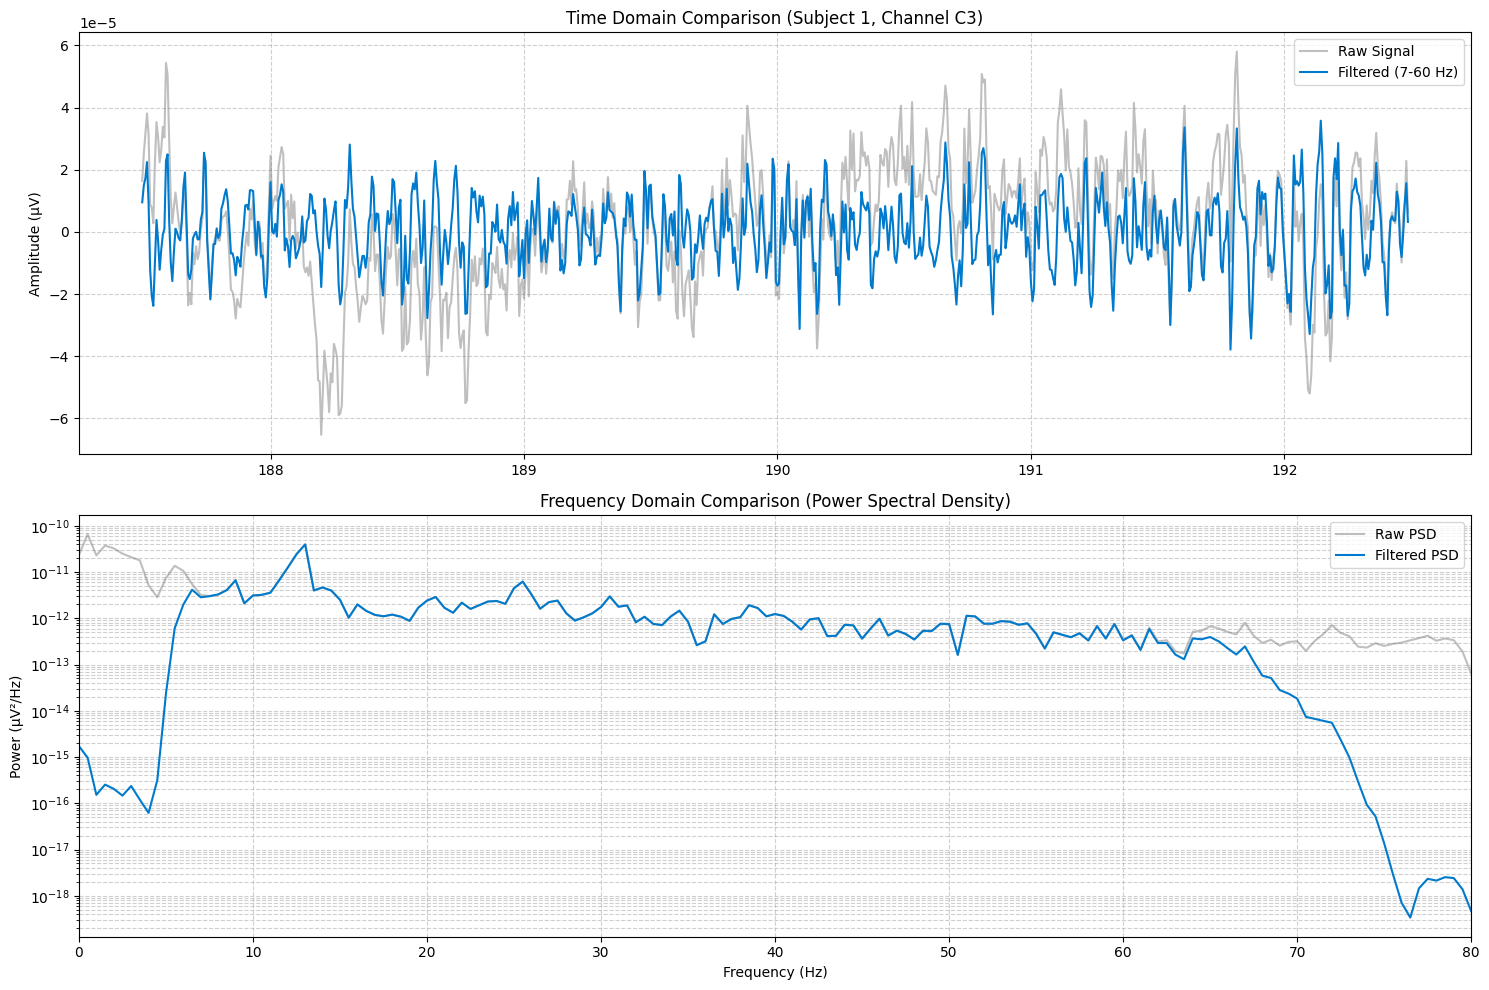

✅ Visualisasi selesai ditampilkan.

✅ Loaded Subject 5/100
✅ Loaded Subject 10/100
✅ Loaded Subject 15/100
✅ Loaded Subject 20/100
✅ Loaded Subject 25/100
✅ Loaded Subject 30/100
✅ Loaded Subject 35/100
✅ Loaded Subject 40/100
✅ Loaded Subject 45/100
✅ Loaded Subject 50/100
✅ Loaded Subject 55/100
✅ Loaded Subject 60/100
✅ Loaded Subject 65/100
✅ Loaded Subject 70/100
✅ Loaded Subject 75/100
✅ Loaded Subject 80/100
✅ Loaded Subject 85/100
✅ Loaded Subject 90/100
✅ Loaded Subject 95/100
✅ Loaded Subject 100/100

📊 Loading Selesai.
Total Skipped/Error: 0

📦 DATA READY!
Shape X: (4215, 64, 881, 1)
Shape y: (4215,)
Train size: 2697, Val size: 675, Test size: 843


In [40]:
X_all = []
y_all = []

warnings.filterwarnings('ignore')

print("\n🔄 Memulai Loading Data... (Ini mungkin memakan waktu)")

final_ch_names = []
final_times = []

skipped_count = 0

for subject_id in SUBJECT_IDS:
    try:
        fnames = mne.datasets.eegbci.load_data(subject_id, RUNS, verbose=False)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames])

        mne.datasets.eegbci.standardize(raw)
        raw.set_montage('standard_1020')

        if raw.info['sfreq'] != FS:
            raw.resample(FS, npad='auto')

        raw.pick(raw.ch_names[:64])
        raw.set_eeg_reference('average', projection=True, verbose=False)
        raw.apply_proj(verbose=False)

        if subject_id == SUBJECT_IDS[0]:
            print(f"\n📈 Membuat Plot Perbandingan Filter untuk Subject {subject_id}...")
            viz_duration = 5.0
            viz_start = raw.times[-1] / 2

            viz_ch_name = 'C3' if 'C3' in raw.ch_names else raw.ch_names[0]

            data_unfiltered, viz_times = raw.get_data(picks=viz_ch_name,
                                                      tmin=viz_start,
                                                      tmax=viz_start+viz_duration,
                                                      return_times=True)
            sig_unfiltered = data_unfiltered[0]

            # Hitung PSD sebelum filter
            f_unfilt, p_unfilt = welch(sig_unfiltered, fs=raw.info['sfreq'], nperseg=int(raw.info['sfreq']*2))

        raw.filter(7., 60., fir_design='firwin', skip_by_annotation='edge', verbose=False)

        if subject_id == SUBJECT_IDS[0]:
            data_filtered, _ = raw.get_data(picks=viz_ch_name,
                                            tmin=viz_start,
                                            tmax=viz_start+viz_duration,
                                            return_times=True)
            sig_filtered = data_filtered[0]

            # Hitung PSD setelah filter
            f_filt, p_filt = welch(sig_filtered, fs=raw.info['sfreq'], nperseg=int(raw.info['sfreq']*2))

            plt.figure(figsize=(15, 10))

            # Plot 1: Time Domain (Overlay)
            plt.subplot(2, 1, 1)
            plt.plot(viz_times, sig_unfiltered, color='gray', alpha=0.5, label='Raw Signal')
            plt.plot(viz_times, sig_filtered, color='#007acc', linewidth=1.5, label='Filtered (7-60 Hz)')
            plt.title(f'Time Domain Comparison (Subject {subject_id}, Channel {viz_ch_name})')
            plt.ylabel('Amplitude (µV)')
            plt.legend(loc='upper right')
            plt.grid(True, linestyle='--', alpha=0.6)

            # Plot 2: Frequency Domain (PSD Comparison)
            plt.subplot(2, 1, 2)
            plt.semilogy(f_unfilt, p_unfilt, color='gray', alpha=0.5, label='Raw PSD')
            plt.semilogy(f_filt, p_filt, color='#007acc', linewidth=1.5, label='Filtered PSD')
            plt.title('Frequency Domain Comparison (Power Spectral Density)')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power (µV²/Hz)')
            plt.xlim(0, 80)
            plt.legend(loc='upper right')
            plt.grid(True, linestyle='--', alpha=0.6, which='both')

            plt.tight_layout()
            plt.show()
            print("✅ Visualisasi selesai ditampilkan.\n")

        events, event_id = mne.events_from_annotations(raw, verbose=False)
        target_events = {k: v for k, v in event_id.items() if k in ['T1', 'T2']}

        if len(target_events) != 2:
            print(f"⚠️ Subject {subject_id} skipped: Missing events.")
            continue

        epochs = mne.Epochs(raw, events, event_id=target_events,
                            tmin=T_MIN, tmax=T_MAX,
                            baseline=None, preload=True, verbose=False)

        if len(final_ch_names) == 0:
            final_ch_names = raw.ch_names
            final_times = epochs.times

        X = epochs.get_data() * 1000
        y = epochs.events[:, -1]

        if X.shape[2] != EPOCH_LENGTH:
            print(f"⚠️ Subject {subject_id} skipped: Dimension Mismatch. Got {X.shape[2]}, expected {EPOCH_LENGTH}")
            skipped_count += 1
            continue

        y_mapped = np.array([0 if x == target_events['T1'] else 1 for x in y])

        X_all.append(X)
        y_all.append(y_mapped)

        if subject_id % 5 == 0:
            print(f"✅ Loaded Subject {subject_id}/{len(SUBJECT_IDS)}")

    except Exception as e:
        print(f"❌ Error Subject {subject_id}: {e}")
        skipped_count += 1

print(f"\n📊 Loading Selesai.")
print(f"Total Skipped/Error: {skipped_count}")

if len(X_all) > 0:
    X_raw = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)

    X_final = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], X_raw.shape[2], 1)

    print(f"\n📦 DATA READY!")
    print(f"Shape X: {X_final.shape}")
    print(f"Shape y: {y.shape}")
else:
    print("❌ Tidak ada data yang berhasil di-load.")

if len(X_all) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

In [41]:
def EEGNet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5,
           kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):

    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)

    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)

    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)

    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    flatten = Flatten(name='flatten')(block2)

    dense = Dense(1, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    output = Activation('sigmoid', name='sigmoid')(dense)

    return Model(inputs=input1, outputs=output)

In [42]:
model = EEGNet(nb_classes=2, Chans=64, Samples=EPOCH_LENGTH,
               dropoutRate=0.5, kernLength=80, F1=8, D=2, F2=16)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_path = 'best_model.keras'
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                               save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("\n🚀 Starting Training...")
history = model.fit(X_train, y_train,
                    batch_size=32, epochs=150,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer, reduce_lr, early_stop],
                    verbose=1)




🚀 Starting Training...
Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4914 - loss: 0.6952
Epoch 1: val_accuracy improved from -inf to 0.50074, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.4914 - loss: 0.6952 - val_accuracy: 0.5007 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5072 - loss: 0.6924
Epoch 2: val_accuracy did not improve from 0.50074
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5072 - loss: 0.6924 - val_accuracy: 0.4993 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5275 - loss: 0.6911
Epoch 3: val_accuracy did not improve from 0.50074
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5274 - loss: 0.6911 - val_accuracy: 0.4963 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5384 - loss: 0.6843
Epoch 4: val_accuracy i

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

🏆 Test Accuracy: 85.05%
              precision    recall  f1-score   support

       Hands       0.84      0.86      0.85       421
        Feet       0.86      0.84      0.85       422

    accuracy                           0.85       843
   macro avg       0.85      0.85      0.85       843
weighted avg       0.85      0.85      0.85       843



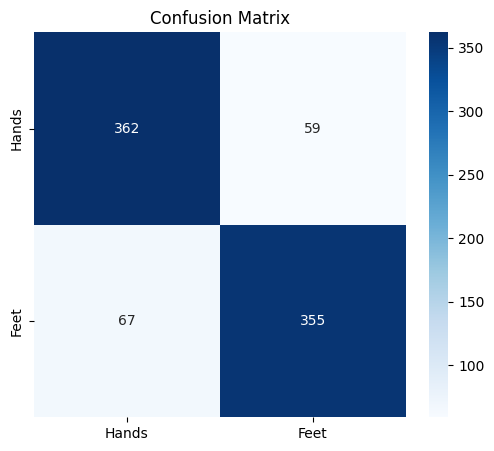

In [43]:
best_model = load_model(checkpoint_path)
probs = best_model.predict(X_test)
preds = (probs > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, preds)
print(f"\n🏆 Test Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, preds, target_names=['Hands', 'Feet']))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hands', 'Feet'], yticklabels=['Hands', 'Feet'])
plt.title('Confusion Matrix')
plt.show()



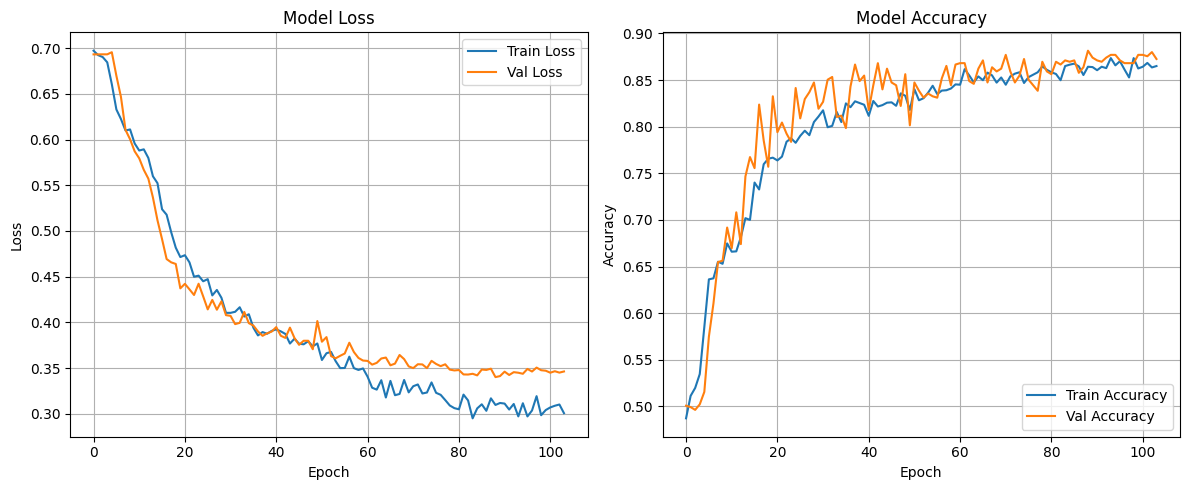

In [44]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


📈 VISUALISASI GRAND AVERAGE (C3, C4, Cz)


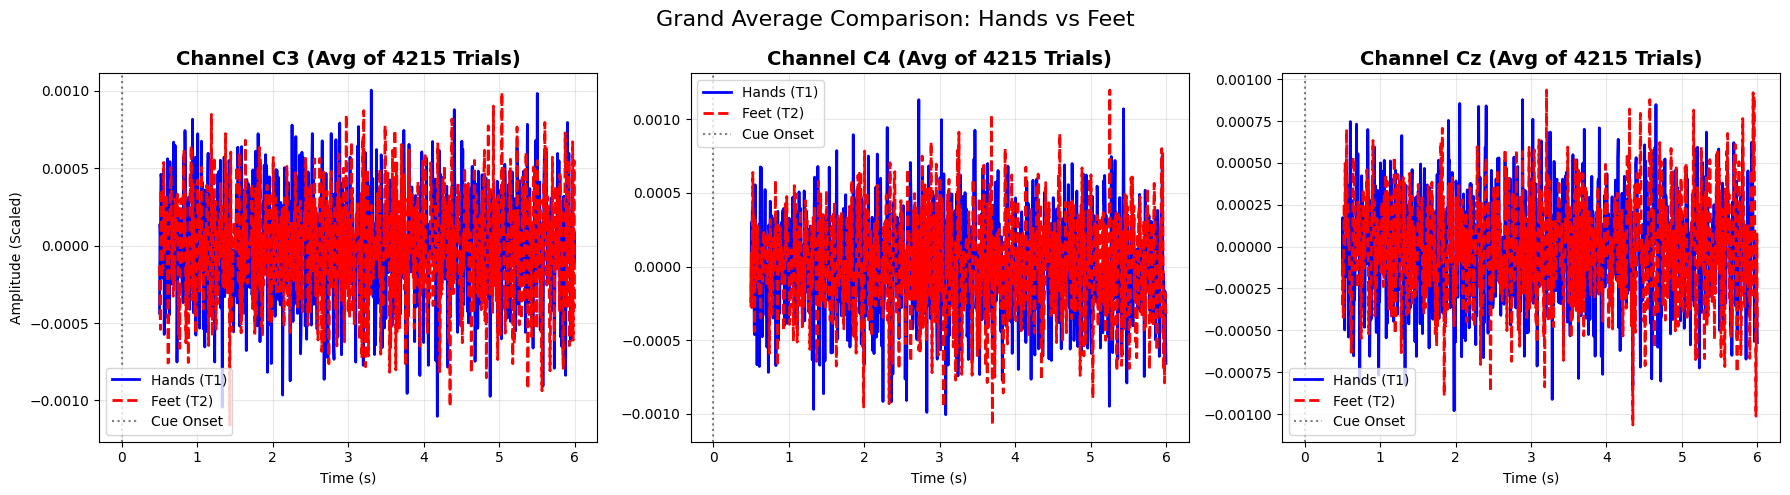

ℹ️ Interpretasi:
- C3 (Kiri): Mengontrol tangan KANAN.
- C4 (Kanan): Mengontrol tangan KIRI.
- Cz (Tengah): Mengontrol KAKI.
- Perbedaan amplitudo/pola antara garis Biru dan Merah menunjukkan pembeda kelas.


In [45]:
print(f"\n{'='*60}")
print("📈 VISUALISASI GRAND AVERAGE (C3, C4, Cz)")
print(f"{'='*60}")

target_chs = ['C3', 'C4', 'Cz']

ch_indices = {}
for ch in target_chs:
    if ch in final_ch_names:
        ch_indices[ch] = final_ch_names.index(ch)

if len(ch_indices) == 3:
    idx_hands = np.where(y == 0)[0]
    idx_feet = np.where(y == 1)[0]

    avg_hands = np.mean(X_raw[idx_hands], axis=0)
    avg_feet = np.mean(X_raw[idx_feet], axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, ch_name in enumerate(target_chs):
        idx = ch_indices[ch_name]
        ax = axes[i]

        data_h = avg_hands[idx]
        data_f = avg_feet[idx]

        ax.plot(final_times, data_h, label='Hands (T1)', color='blue', linewidth=2)
        ax.plot(final_times, data_f, label='Feet (T2)', color='red', linestyle='--', linewidth=2)

        ax.set_title(f'Channel {ch_name} (Avg of {len(y)} Trials)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_ylabel('Amplitude (Scaled)')

        ax.axvline(0, color='k', linestyle=':', alpha=0.5, label='Cue Onset')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')

    plt.suptitle('Grand Average Comparison: Hands vs Feet', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("ℹ️ Interpretasi:")
    print("- C3 (Kiri): Mengontrol tangan KANAN.")
    print("- C4 (Kanan): Mengontrol tangan KIRI.")
    print("- Cz (Tengah): Mengontrol KAKI.")
    print("- Perbedaan amplitudo/pola antara garis Biru dan Merah menunjukkan pembeda kelas.")
else:
    print("⚠️ Channel C3, C4, atau Cz tidak ditemukan dalam dataset.")



In [46]:
print(f"\n{'='*60}")
print("💾 SAVING DEPLOYMENT FILES")
print(f"{'='*60}")

mapping_info = {
    "class_mapping": {"0": "T1 (Hands)", "1": "T2 (Feet)"},
    "sampling_rate": FS,
    "input_shape": [64, EPOCH_LENGTH, 1],
    "note": "Output 0 is Hands, Output 1 is Feet"
}

with open('label_mapping.json', 'w') as f:
    json.dump(mapping_info, f, indent=4)

scaler_info = {
    "type": "manual_multiplier",
    "factor": 1000,
    "description": "Multiply raw EEG data by 1000 before inputting to model"
}
joblib.dump(scaler_info, 'scaler_raw.pkl')

print("✅ Files saved: best_model.keras, label_mapping.json, scaler_raw.pkl")


💾 SAVING DEPLOYMENT FILES
✅ Files saved: best_model.keras, label_mapping.json, scaler_raw.pkl
